## Lab 3: Asking a Statistical Question
## Jennifer Vo, lab partners with William Olsen
In this lab we will focus on asking statistical questions. The entire process typically involves 3 steps:
1. Writing down in words very precisely what question you are trying to ask.
2. Translating the precise english question into a mathematical expression. This often includes determining the pdf of the background (possibly including trials), and then doing the integral to obtain a probability.
3. Coverting the probability into an equivalent sigma value.

In this lab, I will provide information about the background distribution and assume that I know the analytic description or form. In each of the three problems in this lab, my task is to state the statistical question, convert it to math, then perform the associated analyses.

## Problem 1
For this first problem, I am looking at the temperature reading (meta-data) associated with an experiment. For the experiment to work reliably, the temperature should be at around 12 Kelvin. Assume that the data is mostly consistent with 12 Kelvin, to within the 0.4 degree precision of the thermometry and the thermal control system (standard deviation). However, there are times when the thermal control system misbehaved and the temperature was not near 12 K, and in addition there are various glitches in the thermometry that give anomalously high and low readings (the reading does not match the real temperature).

My goal is to identify and throw out all the data when the thermal control system was not working (and the temperature was truly off from nominal). We also want to throw out values when we had an error in the thermometry such that the true temperature was fine, and we just had a wonky reading - just to be cautious.

First, I will import libraries and simulate some data. I will simulate 100k "good" data points assuming Gaussian fluctuations, and will also add the following "bad" datapoints: {10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7}

In [1]:
# First let's import the libraries I will be using
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (10,7)

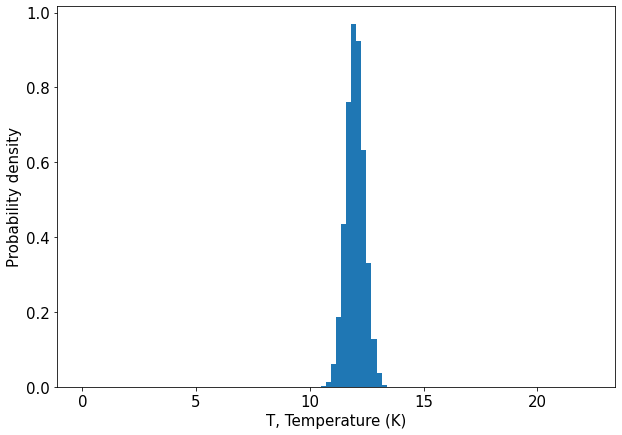

In [2]:
mean_data = 12
std_data = 0.4
N_good = 100000
bad_data = [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7]
N_bad = len(bad_data)
data = np.append(stats.norm.rvs(loc = mean_data, scale = std_data, size = N_good), bad_data)
plt.hist(data,100, density=True)
plt.tick_params(labelsize = 15)
plt.ylabel('Probability density', fontsize = 15)
plt.xlabel('T, Temperature (K)', fontsize = 15)
plt.show()

### Part A.

First, our goal is to identify bad data and throw it out. I will do this by first exploring the data I created with appropriate plots. Let's plot our original distribution onto a semi-log plot. I will also plot a Gaussian probability distribution with mean of 12K and standard deviation of 0.4 K on the same plot to see how the distribution compares.

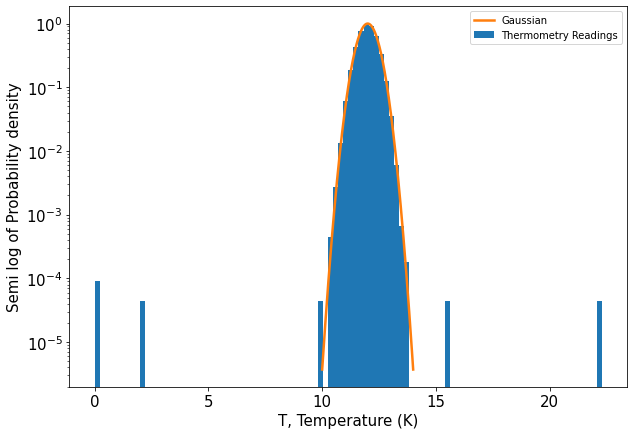

In [3]:
plt.hist(data,100, density=True, label = 'Thermometry Readings')

# Create a linear space for the Gaussian that is +/- 2 away from the mean
x = np.linspace(10,14,1000)
plt.plot(x, stats.norm.pdf(x, loc = mean_data, scale = std_data), linewidth = 2.5, label = 'Gaussian')

plt.yscale('log')
plt.legend()
plt.tick_params(labelsize = 15)
plt.ylabel('Semi log of Probability density', fontsize = 15)
plt.xlabel('T, Temperature (K)', fontsize = 15)
plt.show()

From the semi-log plot, we can observe that the data near the T = 12 K around the distribution mean looks characteristic of the Gaussian distribution, forming an upside-down parabolic shape. The data points at 0, 2.1, 10, 15.6, and 22.3 all appear to be outliers. How do I actually know whether they are anomalies?

The physics community considers data points with a significance of 5$\sigma$ or greater "discoveries", in other words, statistically significant. I will use this threshold to determine which data points I will consider "bad" and therefore throw out. I will ask the following statistical question: 

**"What temperature measurement, greater than the distribution mean of 12 K, would my thermometry reading have to produce in order to give me a statistical significance of 5$\sigma$?"**

The answer to this question will be some degrees Kelvin away from the mean. The question is framed to find temperature measurements above the mean, but I will take the answer and apply the absolute value of (T-12) as temperature differences both above and below the mean when considering data points to drop, as the distribution should be symmetric. (This means a temperature measurement of say, 3 K above the mean would imply dropping data points below 9 K and above 15 K.) Thus, if a temperature measurement gives me a statistical significance of greater than 5$\sigma$, I will assume that the the thermal control system was misbehaving and I will drop that data point.

I need to restate my statistical question in math. 

The probability distribution we will use to model the data is a Gaussian distribution with mean of 12 K and standard deviation of 0.4 K. (Note that the actual Gaussian distribution technically ranges from -$\infty$ to $\infty$, but with probabilities of measuring negative temperatures here being over (12-0)/0.4 = 30 standard deviations away from the mean, we can ignore this minor detail.)

I will need to convert my threshold of 5$\sigma$ to a corresponding probability of obtaining that threshold using the survival function (sf) of scipy.stats.norm with a normal distribution of mean 0 and standard deviation 1. This integrates the normal distribution at x = 5 to x = $\infty$. Then, I will take this calculated probability and use the inverse survival function on a Gaussian with mean 12 K and standard deviation of 0.4 K, to determine what corresponding temperature would give me a significance of 5$\sigma$.

I can convert this question into a mathematical expression, where the answer to the question asked is given by T'. The normal distribution has mean of 0 and standard deviation of 1, so 5$\sigma$ away from the mean is x = 5. The probability we want thus ranges from 5 to $\infty$.

$$ \int_{5}^{\infty} \frac{1}{\sqrt{2\pi}}e^{-x^2/2} dx = \int_{T'}^{\infty} \frac{1}{0.4\sqrt{2\pi}}e^{-\frac{1}{2}((T-12)/0.4)^2} dT $$

Let's convert this math into code and solve for T', the temperature measurement _over_ the mean of 12 K that would give us a statistical significance of 5 $\sigma$.

In [4]:
sigma_a = 5
prob_a = stats.norm.sf(sigma_a)

T_prime = stats.norm.isf(prob_a, loc = mean_data, scale = std_data)
print(f'The temperature measurement greater than the mean of 12 K the thermometry reading would have to produce in order to obtain a statistical significance of 5 sigma or greater is {T_prime:.2f} K')

The temperature measurement greater than the mean of 12 K the thermometry reading would have to produce in order to obtain a statistical significance of 5 sigma or greater is 14.00 K


14 K is exactly 2 K greater than the mean. Since the actual distribution should be symmetric, we would exclude data points that are less than or equal to 10 K (=12K-2K), and greater than or equal to 14 K. 

I can construct a truth table representing the results of the data points that were classified as Good vs Bad data points with my test, and compare that to what were true temperatures (True T) and bad temperatures (Bad T). I know that I created the data with 100k true Gaussian data points and 8 "bad" data points. I can calculate the number of data points that were classified as good and bad according to my test of 5 sigma significance, then I will construct this truth table.

In [5]:
test_count_bad = 0
test_count_good = 0

for i in range (0, len(data)):
    if data[i] <= 10 or data[i] >= 14:
        test_count_bad += 1
    else:
        test_count_good += 1
        
print(f'I have a total of {N_good} true T data points and {N_bad} bad T data points.')
print(f'The total count of bad data points according to my 5 sigma test is {test_count_bad}.')
print(f'The total count of good data points according to my 5 sigma test is {test_count_good}.')

I have a total of 100000 true T data points and 8 bad T data points.
The total count of bad data points according to my 5 sigma test is 6.
The total count of good data points according to my 5 sigma test is 100002.


Thus the following truth table can be constructed:

|  | True T | Bad T|
|----|----|----------|
| My Test Good | 100,000  | 2  |
| My Test Bad | 0  | 6 |

### Part B.

The test I constructed in Part A was based off of a statistical threshold of 5$\sigma$, and from the truth table I can observe that my test did not omit any true temperature readings. 
I would like to explore now the question of how the number of data points my test omits depend on this statistical threshold. If I have a lower statistical threshold, I would expect my test to have an increased number of omissions (throw out true T points).

A higher threshold means a greater sigma is required for "significance" and thus there will be fewer data points acheiving that significance. The number of temperature measurements omitted is a predictable quantity. Sigma is a measure of standard deviation away from the mean of the normal Gaussian distribution (mean of 0 and standard deviation of 1). By definition, a value of 5$\sigma$ means points which are 5 standard deviations away from the mean, and we know that for a threshold of 5$\sigma$, we kept all 100,000 true T readings. Let's convert some common standard deviation ranges to a percentage of the true T readings that would be included within that range:
- +/- 1 $\sigma$ away from the mean includes ~68% of the data
- +/- 2 $\sigma$ away from the mean includes ~95% of the data
- +/- 3 $\sigma$ away from the mean includes ~99% of the data

And so on and so forth. These percentages can easily be looked up, as they are used for reporting confidence intervals in many fields. These probabilities eventually converge to 1 as we increase our statistical threshold to 5$\sigma$. However, what this means is that we can extend these probabilities of sigmas to our own distribution. A significance of 3$\sigma$ in our distribution would omit approximately 1-0.997 = 0.003 or ~0.3% of our true T data. Since our dataset has 100,000 true T points, this means about 300 true T measurements would be omitted in our test using a threshold of 3$\sigma$. Thus, we can take any statistical threshold and calculate a prediction for a corresponding number of true T points omitted by my test.

### Part C.

As we can observe from my truth table construction, there are still 2 bad temperature measurements that were categorized as "good" data in my test. Bad data getting in is also called mistakes of commission. 

These are avoidable if our test can omit them, which depends on our statistical threshold. Lowering the statistical threshold by choosing smaller values of $\sigma$ would result in fewer mistakes of commission, but this would also lead to omission of true temperature data points. Depending on where the bad data points are exactly, our test may not be able to avoid them getting in without sacrificing a significant amount of data. The decision of where the statistical threshold should lie will greatly depend on the experiment in question and where the bad data points are. The closer they are to the mean, the more difficult it is to avoid those mistakes of commission.

## Problem 2

In this problem I will be looking for asteroids. If we look at the alignment of stars on subsequent images, they don't perfectly align due to atmospheric and instrumental effects (even ignoring proper motion). The resulting distribution is two dimensional, and for this lab let's assume it is a 2D Gaussian with 1 arcsecond RMS (another name for standard deviation). If I histogram how far all the (stationary) stars appear to have moved I get something like the result of the following code:

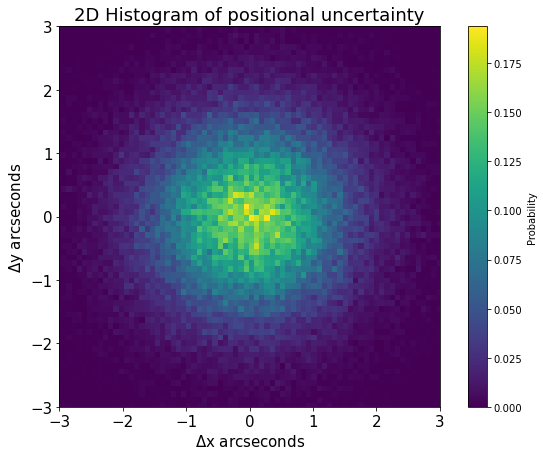

In [7]:
# Note: Both 1 dimensional distributions are Gaussian normal distributions with mean = 0 and standard deviation = 1.
a = np.vstack((stats.norm.rvs(scale = 1, size = 100000), stats.norm.rvs(scale = 1, size = 100000)))
a.shape
fig, ax = plt.subplots(1, 1)
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);
ax.set_aspect('equal', 'box')
plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.tick_params(labelsize = 15)
plt.title("2D Histogram of positional uncertainty", fontsize = 18)
plt.ylabel("$\Delta$y arcseconds", fontsize = 15)
plt.xlabel("$\Delta$x arcseconds", fontsize = 15)
plt.colorbar(h[3], ax=ax, label = 'Probability')
plt.show()

Where x and y are orthogonal spatial directions.

### Part A.
If I have spotted a potential asteroid, it will have some true movement between the images. I would expect to see signals at some distance away from my mean of 0 arcseconds RMS. I want to explore what a '5 sigma' detection of movement would look like, and I want to determine what is that distance in arcseconds?

The statistical question I would like to answer is: 
**"What distance in arcseconds would I need to measure in order for my background to produce a signal with a statistical significance of 5$\sigma$?"**

### Part B.

If x and y are the two independent Gaussian-distributed components (both with mean 0 and standard deviation 1) of our vector measurement, we can calculate the length, $z = \sqrt{x_1^2+x_2^2}$ of our vector and the corresponding probability distribution.

The individual x and y component pdf's are both given by:
$$\text{pdf} (x_i)= \frac{1}{\sqrt{2\pi}}e^{-x_i^2/2}$$

A Rayleigh probability distribution, which maps the probability of different amplitudes of a 2-dimensional vector with Gaussian-distributed components with given standard deviation, is the analytic description that would best fit our background. Therefore, we will use the Rayleigh pdf for our background distribution, where the distribution is defined for z $\geq$ 0 as:
$$\text{pdf(z) = }\frac{z}{\sigma^2}e^{-z^2/(2\sigma^2)}$$
where we would use 1 arcsecond RMS as our $\sigma$.

I will also plot the background distribution of the images with a Rayleigh distribution with scale parameter 1 arcsecond RMS in order to visualize the distribution and determine if the answer to my question makes sense.

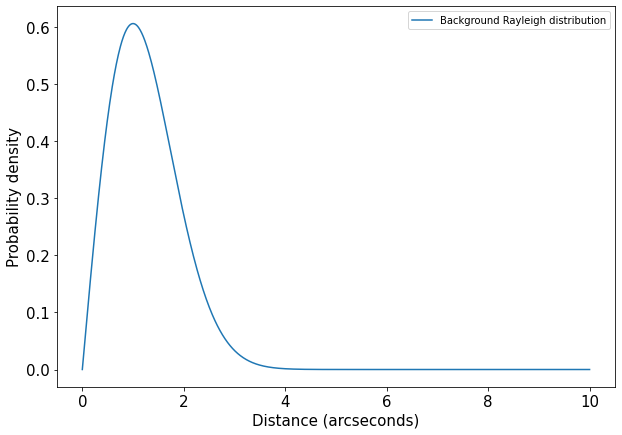

In [13]:
std_rayleigh = 1
d_rayleigh = np.linspace(0,10,1000)
p_rayleigh = stats.rayleigh.pdf(d_rayleigh, scale = std_rayleigh)
plt.plot(d_rayleigh, p_rayleigh, label = 'Background Rayleigh distribution')
plt.tick_params(labelsize = 15)
plt.xlabel("Distance (arcseconds)", fontsize = 15)
plt.ylabel("Probability density", fontsize = 15)
plt.legend()
plt.show()

The probability I would need for a 5$\sigma$ significance can be calculated as in Problem 1, through converting 5 sigma to a corresponding probability with the survival function (sf) using with a normal distribution of mean 0 and standard deviation 1. Then, I will take the calculated probability and use the inverse survival function on a Rayleigh distribution with scale parameter of 1 arcsecond RMS, to determine what distance in arcseconds would give me a significance of 5 $\sigma$.

The normal distribution has mean of 0 and standard deviation of 1, so 5$\sigma$ away from the mean is x = 5. The probability we want thus ranges from 5 to $\infty$. Our statistical question can thus be expressed with the following mathematical equation, where the answer to the question asked is given by z':

$$ \int_{5}^{\infty} \frac{1}{\sqrt{2\pi}}e^{-x^2/2} dx = \int_{z'}^{\infty} \frac{z}{\sigma^2}e^{-z^2/(2\sigma^2)}dz = \int_{z'}^{\infty} z e^{-z^2/2}dz$$

### Part C.

Now, I will compute this distance in arcseconds to determine what signal would represent a 5 sigma detection of motion.

In [14]:
sigma_b = 5
std_rayleigh = 1
prob_b = stats.norm.sf(sigma_b)

z_prime = stats.rayleigh.isf(prob_b, scale = std_rayleigh)
print(f'The distance measurement I would need to detect in order to obtain a statistical significance of 5 sigma or greater is {z_prime:.2f} arcseconds.')

The distance measurement I would need to detect in order to obtain a statistical significance of 5 sigma or greater is 5.49 arcseconds.


As we can observe from the plot, a distance measurement of 5.49 arcseconds looks to be on the far right end of the tail of the distribution, where the probability density is very low. This means sense, as a statistical significance of 5 sigma is required for "discovery" in physics, and a measurement that has a very low probability of occurring would be what we expect to find. This means, if we were to measure any asteroid detection at a distance of 5.49 arcseconds or greater from the mean of 0, we know that the data points represent at least a 5$\sigma$ signal.

## Problem 3

In this problem we are exploring setting up statistical problems with cosmic ray measurements. As we discussed in class, one of the key backgrounds for gamma-ray telescopes are cosmic rays. Cosmic rays are charged particles—usually protons or electrons but can include atomic nuclei such a alpha particles (helium) or iron. Because of their charge cosmic rays spiral in the magnetic field of the galaxy. From the perspective of the Earth they appear to be coming uniformly from all directions like a high energy gas, and the direction the cosmic ray is travelling when it reaches the Earth tells us nothing about where it came from because we don't know what tortured path it has taken through the galaxy to reach us. However, at trillion electron volt energies and above, the spiral loops are fairly big and the sun and the moon will block cosmic rays. This means the sun and the moon appear as holes in the cosmic ray sky (cosmic rays from that direction are absorbed).

Assume in a moon sized patch on the sky we normally have a cosmic ray rate of 1 cosmic ray per minute (arrivals are random in time). If we can observe where the moon is for 8 hours per night (not too close to the horizon) and we observe for 15 days and see 6800 cosmic rays, what is the signficance of our moon shadow detection?

### Part 1
First, I would like to clearly state my statistical question. The interval of measurement over which I take data is 1 minute * 60 minutes/hour * 8 hours/night * 15 days = 7200 minutes. 

Because we are looking for a moon shadow, where the moon absorbs cosmic rays, we are trying to detect a lack of events. Thus, the significance of our moon shadow detection would correspond to the probability of our background producing 6800 cosmic rays _or less_ in the 7200 minutes of detection. Thus, a stronger signal in this case is given by a measurement of fewer cosmic rays.

Thus, the statistical question I would like to ask is precisely:
**"What is the probability (in sigma notation) that the background distribution of cosmic rays from the sky produces a signal that is signal-like or more than my measurement (6800 cosmic rays), over the 7200 minutes of detection?"**

### Part 2

Next I'd like to translate my statistical question to math. Our cosmic ray measurement can only take discrete values, and we know the average rate of background cosmic rays at 1 cosmic ray per minute. I would like to use a Poisson distribution with parameter $\lambda$ = 1 cosmic ray to represent the distribution for a single minute. 

When measuring over 7200 minutes, I would like to sum the measurements to get a total, thus I will sum (convolve) the probability mass functions. Instead of having my poor computer do this task, I will use a convenient property of the Poisson distribution which is that the sum of Poisson-distributed variables with parameters $\lambda_i$ is a Poisson distribution where the parameter is given by $\lambda = \sum_{i}\lambda_i$.

Thus, the probably mass function of the background distribution is given by the following for every potential measurement k (number of cosmic rays):
$$\text{Probability (k)} = \frac{\lambda^k e^{-\lambda}}{k!} = \frac{7200^k e^{-7200}}{k!} $$

Let's also plot our background distribution over 7200 minutes to visualize our function.

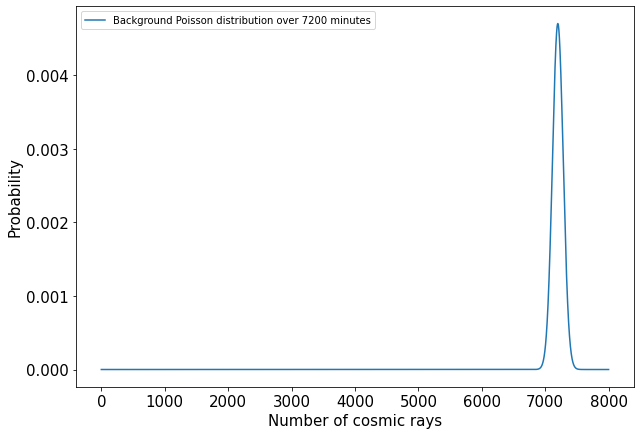

In [15]:
lambda_poisson = 7200
x_poisson = np.linspace(0,8000,8001)
y_poisson = stats.poisson.pmf(x_poisson, lambda_poisson)
plt.plot(x_poisson, y_poisson, label = 'Background Poisson distribution over 7200 minutes')
plt.tick_params(labelsize = 15)
plt.xlabel("Number of cosmic rays", fontsize = 15)
plt.ylabel("Probability", fontsize = 15)
plt.legend()
plt.show()

The sum of these probabilities from x = 0 to 6800 cosmic rays will give me the answer to my question in probability (decimal), but I would like to report the significance level. Thus I will solve for the significance level by equating this total probability to the integral of the normal distribution (mean of 0, standard deviation of 1), such that N$\sigma$ away from the mean is x = N. The probability we want thus ranges from N to $\infty$.

$$ \int_{N}^{\infty} \frac{1}{\sqrt{2\pi}}e^{-x^2/2} dx = \sum_{i=0}^{6800} \frac{7200^i e^{-7200}}{i!} $$

### Part 3
Finally, I will solve this expression to find N, our significance level. I will use the cumulative distribution function to calculate the sum on the right (probability), then I will use the inverse survival function of the normal Gaussian distribution (mean 0 and standard deviation 1) to get the $\sigma$ value that would give me the same probability.

In [16]:
k_poisson = 6800
prob_poisson = stats.poisson.cdf(k_poisson, lambda_poisson)

sigma_poisson = stats.norm.isf(prob_poisson)
print(f'The significance of my measurement of {k_poisson} is {sigma_poisson:.2f} sigma.')

The significance of my measurement of 6800 is 4.75 sigma.


Thus, the answer to the statistical question I posed above is that 4.75$\sigma$ is the significance that my background distribution (cosmic rays from the sky) produces a signal as signal-like or more than my detection of 6800 cosmic rays (over 7200 minutes of data).